In [27]:
import os
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

True

In [28]:
groq_api_key = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]= os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "Arithmetic Agent"


## Define our tools

In [29]:
def multiply(a: int, b: int) -> int:
    """this function multiply two number a and b and return that product
       
       Args:
           a: first int
           b: second int 
    """
    return a*b

def add(a: int, b: int) -> int:
    """
    this function add two number and return and return that sum of two number.
    
    Args:
        a: first number
        b: second number
    """
    return a+b

def divide(a: int, b: int) -> float:
    """This function is divided two number
    Args:
        a: first number
        b: second number
    """
    return a/b
    

In [30]:
llm = ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)
tools = [multiply, add, divide]

In [31]:
llm_with_tools = llm.bind_tools(tools=tools)

In [32]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are helpful assistant tasked with performing arithmetic on a set of inputs")

## node
def assistant(state: MessagesState):
    return {
        "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]
    }

# ***Build the Graph***

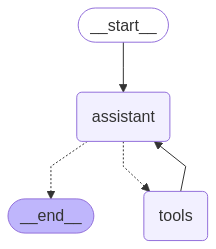

In [33]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import display, Image

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node('tools', ToolNode(tools))

## define the edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    'assistant',
    # if the latest messages (result) from assistant is a tol call -> tools_condition routes to tools
    # if the latest message (result) from assistant is a nota tool call ->tools_condition route to END
    tools_condition,
)

builder.add_edge('tools', 'assistant')

react_graph = builder.compile()


## show the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Now to do testing

In [34]:
messages = HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divided the output by 5")
messages = react_graph.invoke(
    {
        "messages": messages
    }
)

In [35]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divided the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_nfmt)
 Call ID: call_nfmt
  Args:
    a: 3
    b: 4
  multiply (call_95g5)
 Call ID: call_95g5
  Args:
    a: 7
    b: 2
  divide (call_va7z)
 Call ID: call_va7z
  Args:
    a: 14
    b: 5
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

14
================================= Tool Message =================================
Name: divide

2.8
================================== Ai Message ==================================

The final result of the operations is 2.8.


## Updated this agent with the memory

In [38]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

In [39]:
config = {
    "configurable": {
        'thread_id': "chat_1"
    }
}

In [45]:
config['configurable']['thread_id']

'chat_1'

In [50]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divided the output by 5")]

response = react_graph_memory.invoke(
    {
        "messages": messages
    },
    config=config
)

for msg in response['messages']:
    msg.pretty_print()


================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_7c75)
 Call ID: call_7c75
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_cb1e)
 Call ID: call_cb1e
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: multiply

12
================================== Ai Message ==================================
Tool Calls:
  divide (call_cy91)
 Call ID: call_cy91
  Args:
    a: 12
    b: 3
================================= Tool Message =================================
Name: divide

4.0
================================== Ai Message ==================================
Tool Calls:
  add (call_xm4m)
 Call ID: call_xm4m
  

In [51]:
messages = [HumanMessage(content="Multiply that by 2")]

response = react_graph_memory.invoke(
    {
        "messages": messages
    },
    config=config
)

for msg in response['messages']:
    msg.pretty_print()


================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_7c75)
 Call ID: call_7c75
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_cb1e)
 Call ID: call_cb1e
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: multiply

12
================================== Ai Message ==================================
Tool Calls:
  divide (call_cy91)
 Call ID: call_cy91
  Args:
    a: 12
    b: 3
================================= Tool Message =================================
Name: divide

4.0
================================== Ai Message ==================================
Tool Calls:
  add (call_xm4m)
 Call ID: call_xm4m
  